**План проекта**

*   Обработка данных ++
*   Анализ данных++
*   Линейна регрессия ++
*   График анализ результатов++
*   Градиентный Бустинг ++
*   Анализ результатов, Визуализация++



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Загрузка и обработка данных**

In [3]:
import zipfile

with zipfile.ZipFile('archive(1).zip', 'r') as zip_ref:
    zip_ref.extractall()

In [40]:
df = pd.read_csv('games.csv')
df.head()

,title,platforms,rating,votes,developer,release_date,price,genres,url
0,Call of Duty®: Modern Warfare® III - Cross-Gen...,"['PS4', 'PS5']",4.04,334075,Activision,2023-11-02,45.49,['Action'],https://store.playstation.com/en-us/concept/10...
1,Fortnite,['PS5'],4.32,6876621,Epic Games,2017-07-21,0.00,"['Action', 'Adventure']",https://store.playstation.com/en-us/concept/22...
2,NBA 2K24 Kobe Bryant Edition for PS5™,"['PS4', 'PS5']",3.01,33433,2K,2023-09-08,10.49,['Sport'],https://store.playstation.com/en-us/concept/10...
3,Destiny 2 PS4™ & PS5™,"['PS4', 'PS5']",4.28,292806,Bungie,2020-12-08,0.00,"['Shooter', 'Adventure', 'Action']",https://store.playstation.com/en-us/concept/22...
4,EA SPORTS FC™ 24 Standard Edition PS4 & PS5,"['PS4', 'PS5']",3.25,87378,Electronic Arts Inc,2023-09-29,69.99,['Sport'],https://store.playstation.com/en-us/concept/10...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8981 entries, 0 to 8980
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         8981 non-null   object 
 1   platforms     8981 non-null   object 
 2   rating        8981 non-null   float64
 3   votes         8981 non-null   int64  
 4   developer     8981 non-null   object 
 5   release_date  8981 non-null   object 
 6   price         8981 non-null   float64
 7   genres        8981 non-null   object 
 8   url           8981 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 631.6+ KB


In [6]:
df.isna().max()

,0
title,False
platforms,False
rating,False
votes,False
developer,False
release_date,False
price,False
genres,False
url,False


В данных нет пропусков, спасибо автору!

Удаляем сложнообрабатываемы данные. Приэтом мы, к сожалению, теряем графу название, в который может крыться причина успеха вторых частей игр. Обработаем даты год, месяц (в форме синуса-косинуса, так как это периодический признак)

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast


df = df.drop(columns={'url' , 'title'})
X = df
y = df['rating']
z = df['votes']

X['date'] = pd.to_datetime(X['release_date'])
X['year'] = X['date'].dt.year - 2010
X['month'] = X['date'].dt.month
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

mlbp = MultiLabelBinarizer()
mlbg = MultiLabelBinarizer()
X['genres'] = X['genres'].apply(ast.literal_eval)
X['platforms'] = X['platforms'].apply(ast.literal_eval)
platforms_encoded =  pd.DataFrame(mlbp.fit_transform(X['platforms']), columns=mlbp.classes_, index=df.index)
genres_encoded =  pd.DataFrame(mlbg.fit_transform(X['genres']), columns=mlbg.classes_, index=df.index)
X = pd.concat([df, platforms_encoded, genres_encoded], axis=1)

X = X.drop(columns={'genres', 'platforms','rating', 'votes', 'month', 'date', 'release_date'})

X.head()

,developer,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,...,Party,Puzzle,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique
0,Activision,45.49,13,-5.000000e-01,8.660254e-01,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Epic Games,0.00,7,-5.000000e-01,-8.660254e-01,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2K,10.49,13,-1.000000e+00,-1.836970e-16,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Bungie,0.00,10,-2.449294e-16,1.000000e+00,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
4,Electronic Arts Inc,69.99,13,-1.000000e+00,-1.836970e-16,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.15, random_state=42)


Разделили выборку на тренировочную и тестовую

In [43]:
developer_counts = X_train['developer'].value_counts()
X_train['developer_freq'] = X_train['developer'].map(developer_counts)
developer_counts.to_dict()

X_test['developer_freq'] = [developer_counts.get(x, 0) for x in X_test['developer']]
X_test = X_test.drop(columns=['developer'])
X_train = X_train.drop(columns=['developer'])
feature_names = X_train.columns

Применяем частототное кодирование, потому что различных developers очень много, при предсказание легко посчитать кол-во игр вышедших у этой компании, так же для улчшения модели можно добавить признак как средене рейтиногов у прошлых игр этой компании за n последних лет.

In [10]:
X_train

,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,Arcade,...,Puzzle,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique,developer_freq
8864,12.99,13,-5.000000e-01,-0.866025,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,24
3395,19.99,6,-5.000000e-01,0.866025,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,43
3299,14.99,13,5.000000e-01,-0.866025,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,21
3459,9.99,6,-8.660254e-01,-0.500000,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,76
6119,19.99,13,-8.660254e-01,0.500000,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,4.99,8,8.660254e-01,0.500000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5
5191,0.00,12,-8.660254e-01,0.500000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61
5390,5.99,12,-2.449294e-16,1.000000,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,58
860,19.99,14,5.000000e-01,-0.866025,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,17


**Анализ данных:**

смотрим на распределение rating

In [11]:
import seaborn as sns

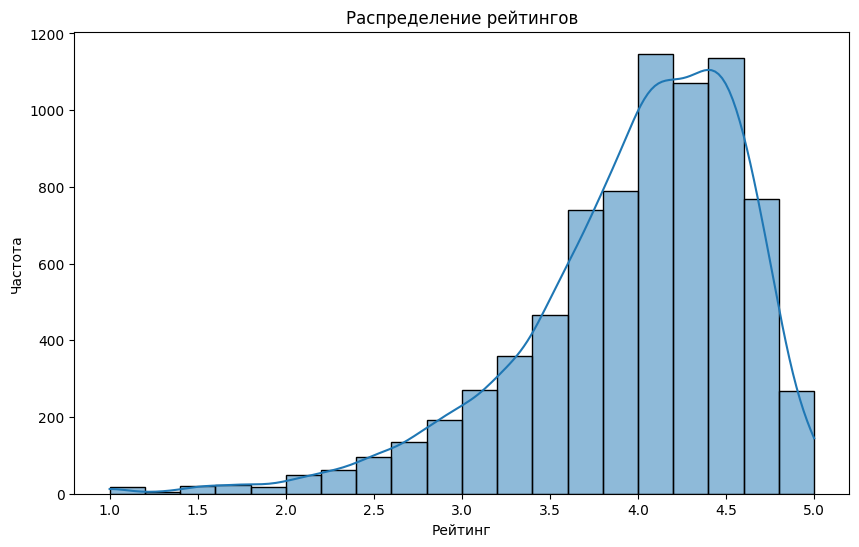

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=20)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

А теперь распределение votes

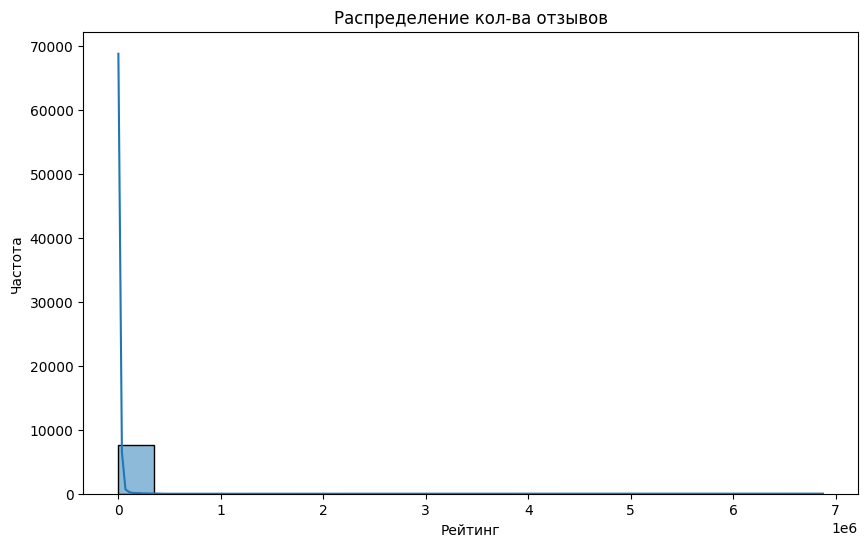

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(z_train, kde=True, bins=20)
plt.title('Распределение кол-ва отзывов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

Почти половина игра имеет рейтинг в интервале (4.0-4.5), а болшинство игр имеет маленькое кол-во отзывов

Теперь построим корреляционную матрицу.

# Большие корреляции у года и Ps_5 (так как PS_5 вышла недавно), у Quiz и Brain Training. Странная корреляция у синуса месяца и год, это забавно))

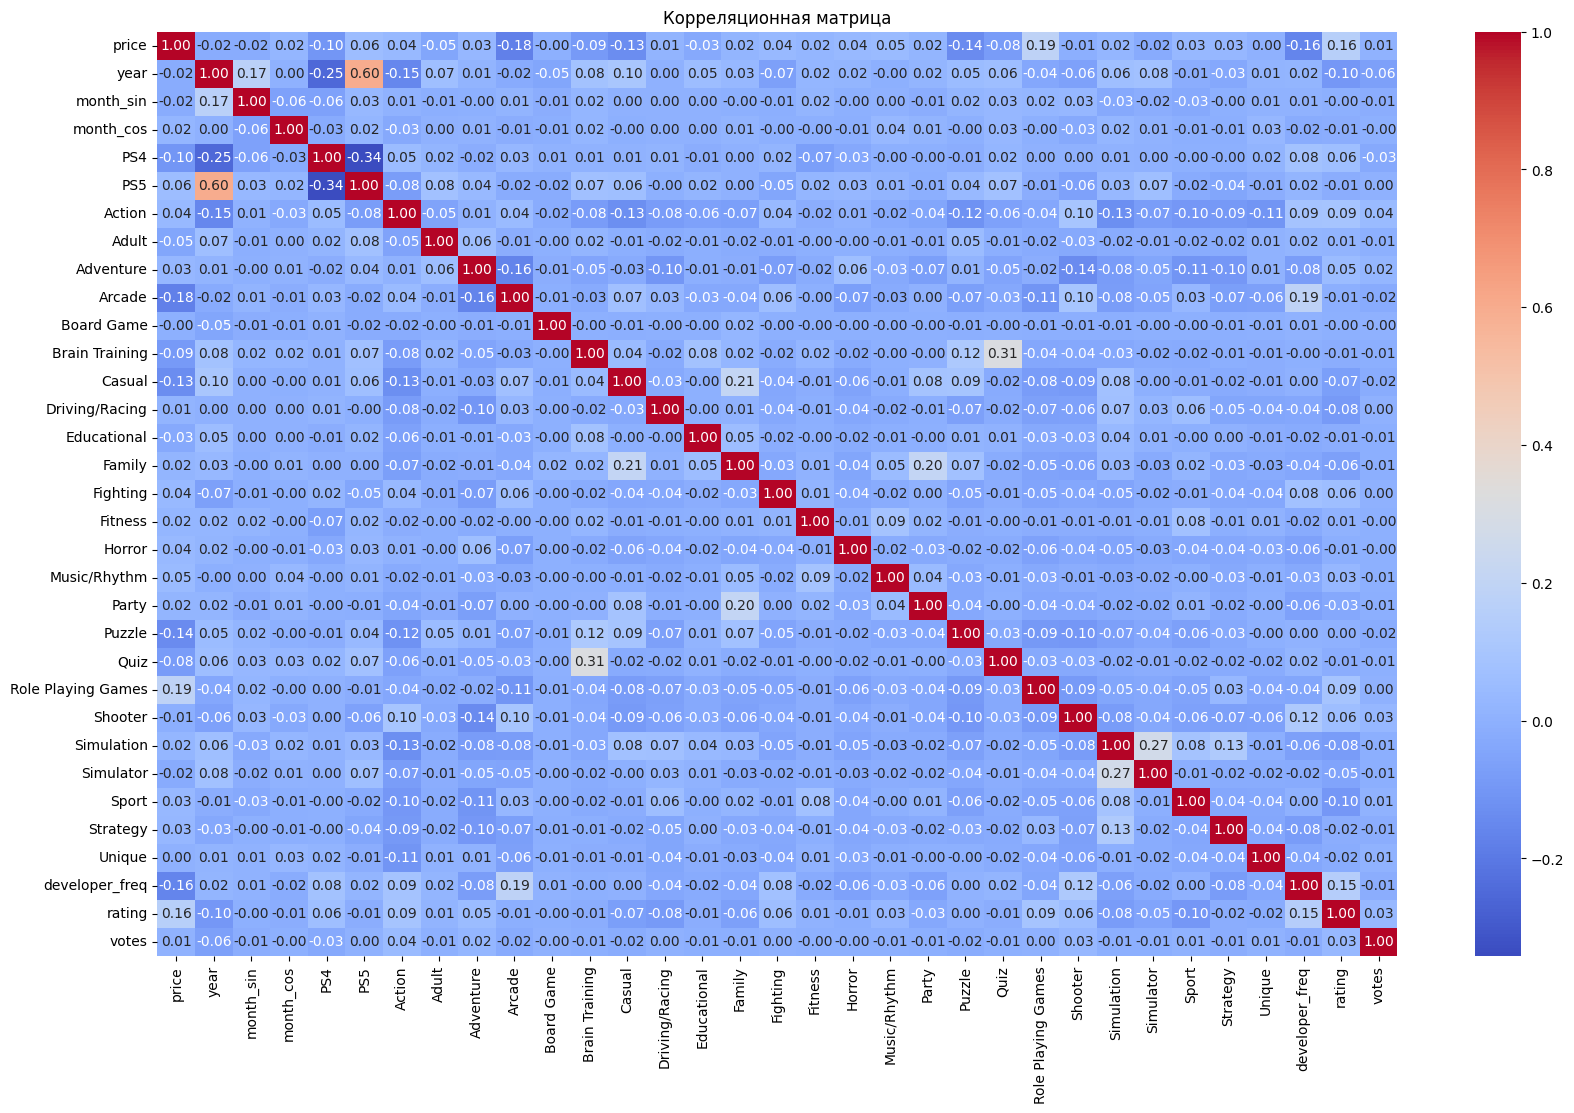

In [14]:
G = pd.concat([X_train, y_train, z_train], axis=1)

corr = G.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Большие корреляции у года и Ps_5 (так как PS_5 вышла недавно), у Quiz и Brain Training. Странная корреляция у синуса месяца и год, это забавно)) Так же можно понять для каких игр ожидаемый рейтинг будет выше.


Выводы:
1) Рейтинг. Сильно зависит от цены, года (но не от месяца, то есть нет сезонности), актвиности компании, еще для категорий RolePlaying game, Sport, DrivingRacing.
2) Кол-во отзывов (~популярность). удивительно что некоррелирован с ценой!!, единственная немаленькая корреляция с годом

**Применем самую просутю линейную регрессию**

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

modely = LinearRegression()
modelz = LinearRegression()
modely.fit(X_train, y_train)
modelz.fit(X_train, z_train)

LinearRegression()

In [16]:
y_train_pred = modely.predict(X_train)
mape_test = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_test:.4f}')
print(f'Train y (rating) RMSE: {rmse_test:.4f}')

y_test_pred = modely.predict(X_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f'Test y (rating) RMSE: {rmse_test:.4f}')

Train y (rating) MAPE: 0.1372
Train y (rating) RMSE: 0.6057
Test y (rating) MAPE: 0.1394
Test y (rating) RMSE: 0.6128


In [17]:
z_train_pred = modelz.predict(X_train)
mape_test = mean_absolute_percentage_error(z_train, z_train_pred)
rmse_test = np.sqrt(mean_squared_error(z_train, z_train_pred))
print(f'Train z (votes) MAPE: {mape_test:.4f}')
print(f'Train z (votes) RMSE: {rmse_test:.4f}')

z_test_pred = modelz.predict(X_test)
mape_test = mean_absolute_percentage_error(z_test, z_test_pred)
rmse_test = np.sqrt(mean_squared_error(z_test, z_test_pred))
print(f'Test z (votes) MAPE: {mape_test:.4f}')
print(f'Test z (votes) RMSE: {rmse_test:.4f}')

Train z (votes) MAPE: 276.1577
Train z (votes) RMSE: 85556.6565
Test z (votes) MAPE: 266.8050
Test z (votes) RMSE: 27398.9408


In [18]:
y_test_pred = pd.Series(y_test_pred, index=y_test.index)

In [19]:
X_test[np.abs(y_test_pred - y_test) > 1.5]

,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,Arcade,...,Puzzle,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique,developer_freq
7072,4.99,13,5.000000e-01,8.660254e-01,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41
3095,39.99,12,-5.000000e-01,8.660254e-01,1,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,5
4067,16.99,11,8.660254e-01,5.000000e-01,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,2
7305,6.99,13,5.000000e-01,-8.660254e-01,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,23
4667,2.49,9,-5.000000e-01,8.660254e-01,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,33
8138,19.99,13,-8.660254e-01,-5.000000e-01,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,26
1149,39.99,13,-5.000000e-01,8.660254e-01,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,28
6553,2.99,13,-2.449294e-16,1.000000e+00,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,15
6625,4.99,13,-1.000000e+00,-1.836970e-16,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43
3649,14.49,13,5.000000e-01,-8.660254e-01,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


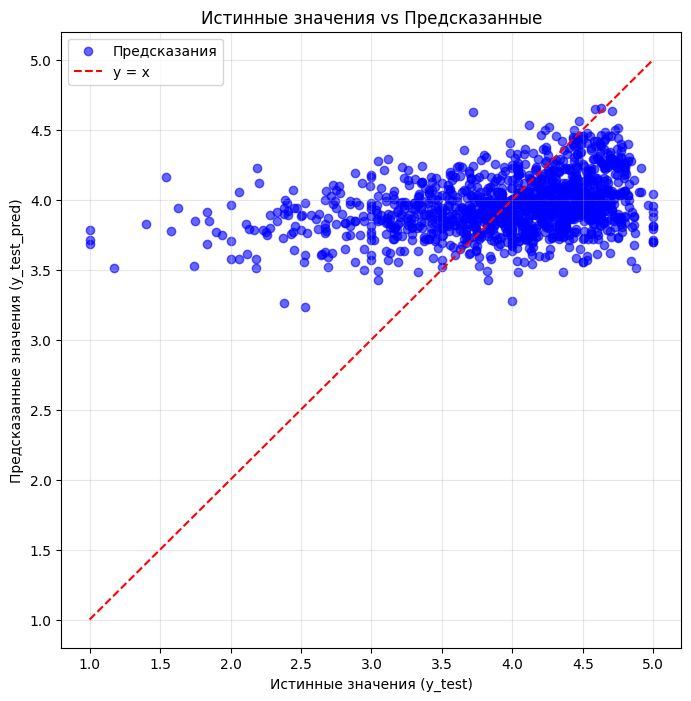

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Предсказания')

max_val = max(max(y_test), max(y_test_pred))
min_val = min(min(y_test), min(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

plt.title('Истинные значения vs Предсказанные')
plt.xlabel('Истинные значения (y_test)')
plt.ylabel('Предсказанные значения (y_test_pred)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

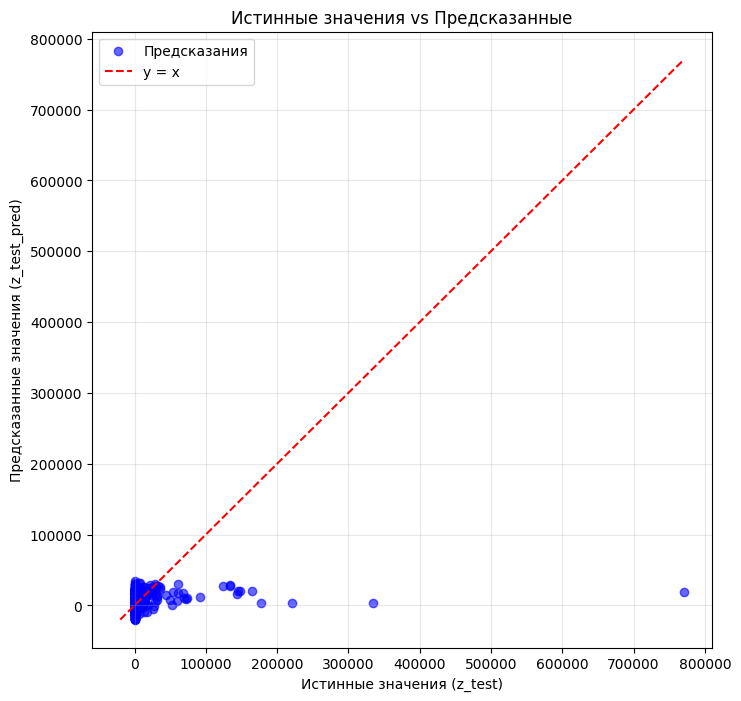

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(z_test, z_test_pred, alpha=0.6, color='blue', label='Предсказания')

max_val = max(max(z_test), max(z_test_pred))
min_val = min(min(z_test), min(z_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

plt.title('Истинные значения vs Предсказанные')
plt.xlabel('Истинные значения (z_test)')
plt.ylabel('Предсказанные значения (z_test_pred)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Результаты не очень хорошие, но  в данных много выборосов, как например игра с почти 800000 отзывов или игры с рейтингом 1. Они достаточно сильно ухудшают RMSE, но удалять такие вборосы нельзя, так как они случаются и в реальной жизни.

Теперь Градиентный бустинг

In [22]:
X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(X_train, y_train, z_train, test_size=0.1, random_state=42)

In [23]:
from lightgbm import LGBMRegressor

modellbgm_y = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
modellbgm_z = LGBMRegressor(n_estimators=40, learning_rate=0.1, max_depth=6, random_state=42)
modellbgm_y.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
y_test_pred = modellbgm_y.predict(X_test)
y_train_pred = modellbgm_y.predict(X_train)
modellbgm_z.fit(X_train, z_train, eval_set=[(X_val, z_val)], eval_metric='rmse')
z_test_pred = modellbgm_z.predict(X_test)
z_train_pred = modellbgm_z.predict(X_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 6869, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.970319
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 6869, number of used features: 29
[Ligh

In [24]:
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")

Train y (rating) MAPE: 0.0964
Train y (rating) RMSE: 0.4388
Test y (rating) MAPE: 0.1251
Test y (rating)  RMSE: 0.5619


In [25]:
mape_train = mean_absolute_percentage_error(z_train, z_train_pred)
rmse_train = np.sqrt(mean_squared_error(z_train, z_train_pred))
print(f'Train z (votes) MAPE: {mape_train:.4f}')
print(f"Train z (votes) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(z_test, z_test_pred)
rmse_test = np.sqrt(mean_squared_error(z_test, z_test_pred))
print(f'Test z (votes) MAPE: {mape_test:.4f}')
print(f"Test z (votes) RMSE: {rmse_test:.4f}")

Train z (votes) MAPE: 56.3689
Train z (votes) RMSE: 78343.3302
Test z (votes) MAPE: 46.4196
Test z (votes) RMSE: 33467.3918


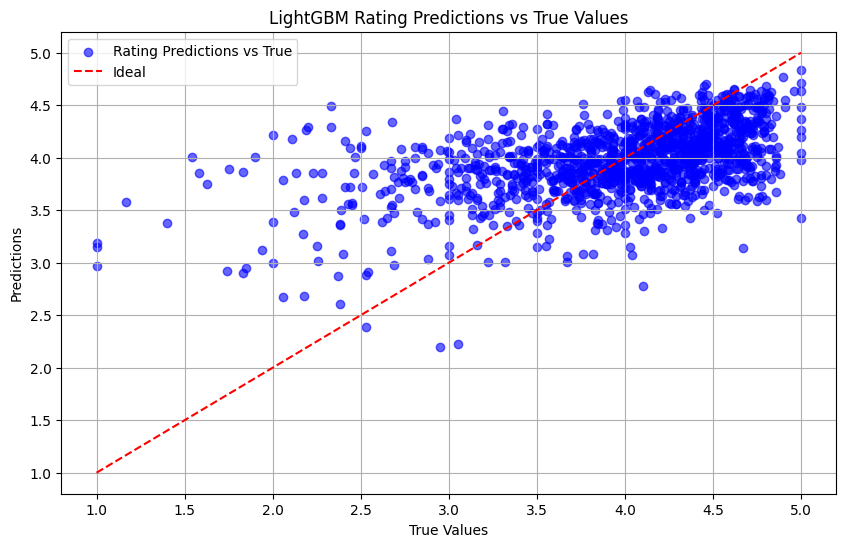

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Rating Predictions vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('LightGBM Rating Predictions vs True Values')
plt.legend()
plt.grid()
plt.show()

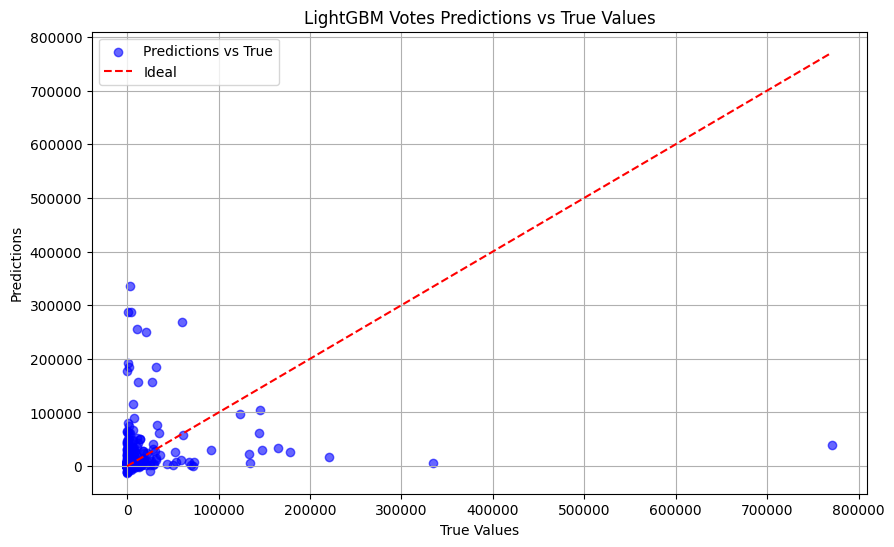

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(z_test, z_test_pred, alpha=0.6, color='blue', label='Predictions vs True')
plt.plot([min(z_test), max(z_test)], [min(z_test), max(z_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('LightGBM Votes Predictions vs True Values')
plt.legend()
plt.grid()
plt.show()

Гардиентый бустинг показал лучшие результаты по сранвению с самой базовой Линейной регрессией. Посмотрим ее важность признаков.


Теперь фокусируемся на предсказании rating и попробуем улучшить результаты. Для начала попробуем подобрать лучшие гиперпараметры в градиентном бустинге.

In [28]:
model_y = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=12, random_state=42)
model_y.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
y_test_pred = model_y.predict(X_test)
y_train_pred = model_y.predict(X_train)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 6869, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.970319
Train y (rating) MAPE: 0.1064
Train y (rating) RMSE: 0.4811
Test y (rating) MAPE: 0.1246
Test y (rating)  RMSE: 0.5563


In [303]:
from sklearn.model_selection import GridSearchCV,  KFold

model = LGBMRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [5, 10, 20, 30],
    'feature_fraction': [0.8, 1.0],
    'bagging_fraction': [0.8, 1.0],

}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train2, y_train2)

print("Best parametres:", grid_search.best_params_)
print("Best parametres:", -grid_search.best_score_)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


KeyboardInterrupt: 

Best parametres: {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}
Best parametres: 0.5662339760325142

In [29]:
model_y = LGBMRegressor(bagging_fraction= 0.8, feature_fraction= 0.8, learning_rate= 0.05, max_depth= 6, min_child_samples= 20, n_estimators= 300, num_leaves= 31)
model_y.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
y_test_pred = model_y.predict(X_test)
y_train_pred = model_y.predict(X_train)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 6869, number of used features: 29
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored.

Сильно улучшить не получается.

У нас задача регрессии и, причем, 8000 объектов достаточно мало для глубоких нейронных сетей из популрной модели которую мы еще не пробали это Random forest.

In [30]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.15, random_state=42)

developer_counts = X_train['developer'].value_counts()
X_train['developer_freq'] = X_train['developer'].map(developer_counts)
developer_counts.to_dict()

X_test['developer_freq'] = [developer_counts.get(x, 0) for x in X_test['developer']]
X_test = X_test.drop(columns=['developer'])
X_train = X_train.drop(columns=['developer'])

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")


Train y (rating) MAPE: 0.0488
Train y (rating) RMSE: 0.2297
Test y (rating) MAPE: 0.1263
Test y (rating)  RMSE: 0.5698


In [307]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best RMSE: 0.563045477611622

In [32]:
rf_model = RandomForestRegressor(max_depth=29, min_samples_leaf=4, min_samples_split=10, n_estimators= 700)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")

Train y (rating) MAPE: 0.0909
Train y (rating) RMSE: 0.4157
Test y (rating) MAPE: 0.1251
Test y (rating)  RMSE: 0.5579


Ничего не помогает добавим признак - среднее рейтингов игр данной команды если игр хотя бы пять (иначе модель плохо будет учиться) иначе ноль

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_csv('games.csv')
df.head()

df = df.drop(columns={'url' , 'title'})
X = df
y = df['rating']

X['date'] = pd.to_datetime(X['release_date'])
X['year'] = X['date'].dt.year - 2010
X['month'] = X['date'].dt.month
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

mlbp = MultiLabelBinarizer()
mlbg = MultiLabelBinarizer()
X['genres'] = X['genres'].apply(ast.literal_eval)
X['platforms'] = X['platforms'].apply(ast.literal_eval)
platforms_encoded =  pd.DataFrame(mlbp.fit_transform(X['platforms']), columns=mlbp.classes_, index=df.index)
genres_encoded =  pd.DataFrame(mlbg.fit_transform(X['genres']), columns=mlbg.classes_, index=df.index)
X = pd.concat([df, platforms_encoded, genres_encoded], axis=1)

X = X.drop(columns={'genres', 'platforms', 'votes', 'month', 'date', 'release_date'})

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

A = X_train.groupby('developer')['rating'].agg(['mean', 'count']).reset_index()
A['mean_rating'] = A.apply(
    lambda row: row['mean'] if row['count'] >= 8 else 0, axis=1
)
A_mean = dict(zip(A['developer'], A['mean']))
A_counts = dict(zip(A['developer'], A['count']))

X_train['mean_rating'] = X_train['developer'].map(A_mean)
X_train['developer_freq'] = X_train['developer'].map(A_counts)
X_test['mean_rating'] = [A_mean.get(x, 0) for x in X_test['developer']]
X_test['developer_freq'] = [A_counts.get(x, 0) for x in X_test['developer']]
X_test = X_test.drop(columns=['developer', 'rating'])
X_train = X_train.drop(columns=['developer', 'rating'])

In [35]:
X_train.head()

,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,Arcade,...,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique,mean_rating,developer_freq
8864,12.99,13,-0.500000,-0.866025,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,3.480833,24
3395,19.99,6,-0.500000,0.866025,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4.101395,43
3299,14.99,13,0.500000,-0.866025,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,3.915238,21
3459,9.99,6,-0.866025,-0.500000,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,4.080263,76
6119,19.99,13,-0.866025,0.500000,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,4.098571,7


Применим те же модели еще раз

LGBM

In [36]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

LGBMR_y = LGBMRegressor(bagging_fraction= 0.7, feature_fraction= 0.7, learning_rate= 0.05, max_depth= 6, min_child_samples= 40, n_estimators= 50, num_leaves= 16)
LGBMR_y.fit(X_train2, y_train2, eval_set=[(X_val, y_val)], eval_metric='rmse')
y_test_pred = LGBMR_y.predict(X_test)
y_train_pred = LGBMR_y.predict(X_train2)

mape_train = mean_absolute_percentage_error(y_train2, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train2, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 6869, number of used features: 30
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] baggin

Random Forest

In [37]:
rf_model = RandomForestRegressor(max_depth=15, min_samples_leaf=30, min_samples_split=20, n_estimators= 50)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y (rating) MAPE: {mape_train:.4f}')
print(f"Train y (rating) RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y (rating) MAPE: {mape_test:.4f}')
print(f"Test y (rating)  RMSE: {rmse_test:.4f}")

Train y (rating) MAPE: 0.0854
Train y (rating) RMSE: 0.4193
Test y (rating) MAPE: 0.1475
Test y (rating)  RMSE: 0.7990


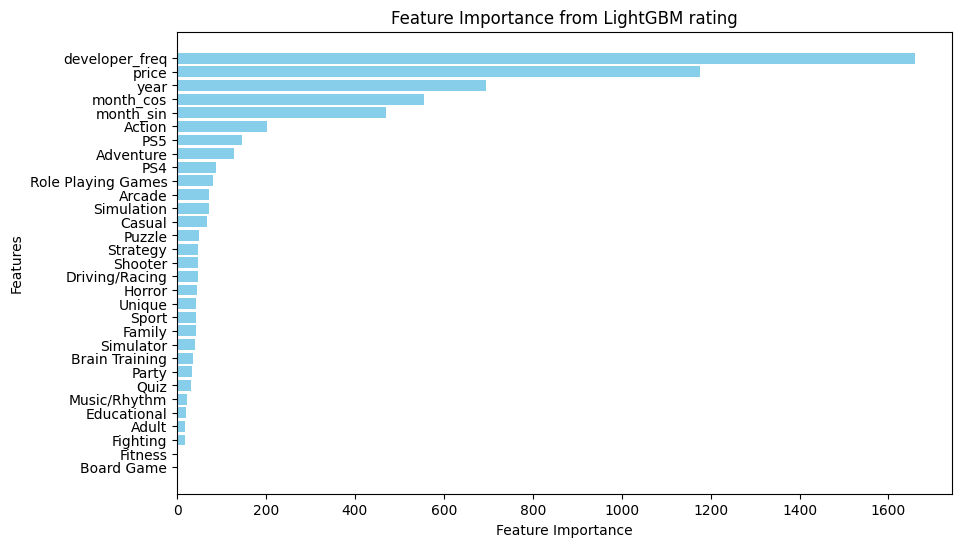

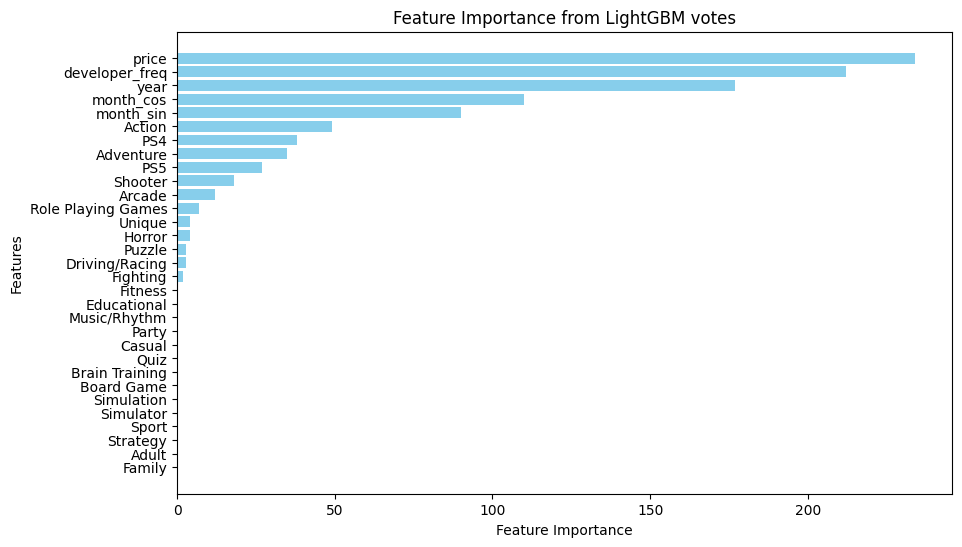

In [44]:
feature_importances_y = modellbgm_y.feature_importances_
feature_importances_z = modellbgm_z.feature_importances_


importance_y = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_y
}).sort_values(by='Importance', ascending=False)

importance_z = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_z
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_y['Feature'], importance_y['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM rating')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(importance_z['Feature'], importance_z['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM votes')
plt.show()

Улучшить не получилось, бывает... Не понятно почему

Теперь проанализируем важность призанаков согласно первой LGBMR

Как и ожидалось самые важные признаки price, dev_freq, monthS, PS_4, Ps_5, year (на самом деле для votes корреляция с этим призанакми маленькая, но корелляция это же не всегда зависимость)

Забавно.   Играм Action особенно часто оставляют отзывы (и корр с этим признаком большая) (может быть так как они вызвают больше эмоций, выливающихся в отзыв) (так же как Shooter и Adventure) Ёще одно объяснение, что объектов обладающих этими призаков просто больше, но это не обясняет, например, разницу в важности Action в почти два раза при предскаазнии rating и votes.




В итоге мы првиели произвели анализ данных и построили несколько моделей предсказывающих рейтинг фильма. К сожалению, результаты получились не самые лучшие.